# Unsupervised Learning: Clustering Lab





In [202]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering as AC, KMeans
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score as mis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
from scipy.spatial.distance import cdist
from itertools import combinations

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The total SSE of the full clustering. 


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
* The SSE of that cluster. (The sum squared error (SSE) of a single cluster is the sum of the squared euclidean distance of each cluster member to the cluster centroid.)
---
You only need to handle continuous features

In [233]:
class HACClustering(BaseEstimator,ClusterMixin):
    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
    def fit(self,X,y=None,normalize = True):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don’t need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        n = X.shape[0]
        m = X.shape[1]
        if normalize:
            minx = np.min(X,axis = 0)
            maxx = np.max(X,axis = 0)
            X = (X-minx)/(maxx-minx)
        D = cdist(X,X) + np.eye(n)*99
        n_clusters = n
        cur_labels = np.arange(n)
        if self.link_type == 'single':
            while n_clusters > self.k:
                try:
                    i,j = np.where(D==np.min(D))[0]
                except:
                    #print(np.where(D == np.min(D)))
                    i, j = np.where(D== np.min(D))[0][0], np.where(D == np.min(D))[1][0]
                cur_labels[cur_labels == cur_labels[j]] = cur_labels[i]
                #print(np.round(D,3))
                D[i,j] = 99
                D[j,i] = 99
                #print(cur_labels)
                n_clusters = np.unique(cur_labels).shape[0]
        else:
            while n_clusters > self.k:
                #print(n_clusters,end = ' ’)
                combos = combinations(np.unique(cur_labels),2)
                combis = []
                #print(combos)
                dists = []
                for ci, cj in combos:
                    combis.append([ci,cj])
                    ci_indices = np.where(cur_labels == ci)[0]
                    cj_indices = np.where(cur_labels == cj)[0]
                    #print(D)
                    #print(D[ci_indices,cj_indices])
                    dists.append(np.max([[D[ci_index,cj_index] for ci_index in ci_indices] for cj_index in cj_indices]))
                #print(dists)
                #print(np.argmin(dists))
                merge_i, merge_j = list(combis)[np.argmin(dists)]
                cur_labels[cur_labels == cur_labels[merge_j]] = cur_labels[merge_i]
                #print(np.round(D,3))
                #D[i,j] = 99
                #D[j,i] = 99
                #print(cur_labels)
                n_clusters = np.unique(cur_labels).shape[0]
        #print(n_clusters)
        #print(cur_labels)
        cts = np.zeros(self.k)
        sses = np.zeros(self.k)
        centroids = np.zeros((self.k,m))
        for i,l in enumerate(np.unique(cur_labels)):
            cts[i] = cur_labels[cur_labels == l].shape[0]
            centroids[i] = np.mean(X[cur_labels ==l],axis = 0)
            self.centroids = centroids
        for i,x in enumerate(X):
            l = cur_labels[i]
            ind = list(np.unique(cur_labels)).index(l)
            sses[ind] += np.linalg.norm(x-self.centroids[ind])**2
        self.cts = cts
        self.sses = sses
        #print(self.cts)
        #print(self.centroids)
        #print(self.sses)
        return self

    def print_clusters(self):
        """
            Used for grading.
            print("{:d}\n".format(k))
            print("{:.4f}\n\n".format(total SSE))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("\n")
                print("{:d}\n".format(size of cluster))
                print("{:.4f}\n\n".format(SSE of cluster))
        """
        print("{:d}".format(self.k))
        print("{:.4f}\n".format(np.sum(self.sses)))
        i = 0
        for ct, cent in zip(self.cts, self.centroids):
            print(np.array2string(cent,precision=4,separator=","))
            print(f"{int(ct)}")
            print("{:.4f}\n".format(self.sses[i]))
            i+=1

### 1.1.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.



- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting SSE and centroid values.


---
Solutions in files:

[Debug HAC Single.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link.txt)

[Debug HAC Complete.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link.txt)

In [234]:
data = pd.DataFrame(arff.loadarff('datasets/abalone.arff')[0], dtype=float)
X = data.values
HAC = HACClustering(k=5)
HAC.fit(X)
HAC.print_clusters()

5
54.4392

[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195
54.3917

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1
0.0000

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2
0.0475

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1
0.0000

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1
0.0000



In [235]:
hac = HACClustering(k = 5,link_type = 'complete')
hac.fit(X,normalize = True)
hac.print_clusters()

5
13.0824

[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71
3.8232

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67
5.2786

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38
1.4989

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16
1.5328

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8
0.9490



### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

In [236]:
data = pd.DataFrame(arff.loadarff('datasets/seismic-bumps_train.arff')[0], dtype=float)
X = data.values
HAC = HACClustering(k=5)
HAC.fit(X)
HAC.print_clusters()

5
22.4548

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1
0.0000

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1
0.0000

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1
0.0000

[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67
10.0257

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70
12.4291



In [237]:
hac = HACClustering(k = 5,link_type = 'complete')
hac.fit(X,normalize = True)
hac.print_clusters()

5
15.6967

[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49
5.0209

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3
0.2178

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18
2.2794

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49
6.3712

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21
1.8075



### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The total SSE of the full clustering. 


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
- The SSE of that cluster. (The sum squared error (SSE) of a single cluster is the sum of the squared euclidean distance of each cluster member to the cluster centroid.)
---
You only need to handle continuous features

In [50]:
class KMEANSClustering(BaseEstimator,ClusterMixin):
    def __init__(self,k=3,debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
    def fit(self,X,y=None,maxiter = 1000,normalize = True):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don’t need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        k = self.k
        m,n = X.shape
        if normalize:
            minx = np.min(X,axis = 0)
            maxx = np.max(X,axis = 0)
            X = (X-minx)/(maxx-minx)
        minx = np.min(X,axis = 0)
        maxx = np.max(X,axis = 0)
        #print(minx,maxx)
        if self.debug:
            self.centroids = X[:k]
        else:
            self.centroids = np.random.uniform(minx,maxx,(self.k,X.shape[1]))
        self.new_centroids = np.zeros_like(self.centroids)
        
        cur_labels = np.zeros((m,),dtype = int)
        cts = np.zeros(k,)
        for i in range(maxiter):
            cur_labels = self.classify(X)
            #print(cur_labels)
            #print(cur_labels)
            for j in range(k):
                if j in cur_labels:
                    self.new_centroids[j] = np.mean(X[cur_labels == j],axis = 0)
                else:
                    self.new_centroids[j] = self.centroids[j]
            for j in range(k):
                cts[j] = X[cur_labels == j].shape[0]
            sses = np.zeros((k,))
            for l,x in zip(cur_labels,X):
                sses[l] += np.linalg.norm(x-self.centroids[l])**2
            #print(sses)
            #print(centroids, new_centroids)
            #print(np.linalg.norm(self.centroids-self.new_centroids))
            if np.linalg.norm(self.centroids-self.new_centroids) < 1e-5:
                print(f'exiting at {i+1} iters')
                self.centroids = self.centroids
                self.cts = cts
                self.sses = sses
                break
            self.centroids = self.new_centroids.copy()
        return self
    def classify(self, X):
        #print([(np.linalg.norm(row-self.centroids, axis=1)) for row in X])
        return np.array([np.argmin(np.linalg.norm(row-self.centroids, axis=1)) for row in X])
    def print_clusters(self):
        """
            Used for grading.
            print(“{:d}\n”.format(k))
            print(“{:.4f}\n\n”.format(total SSE))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=“,”))
                print(“\n”)
                print(“{:d}\n”.format(size of cluster))
                print(“{:.4f}\n\n”.format(SSE of cluster))
        """
        print("{:d}".format(self.k))
        print("{:.4f}\n".format(np.sum(self.sses)))
        i = 0
        for ct, cent in zip(self.cts, self.centroids):
            print(np.array2string(cent,precision=4,separator=','))
            print(f'{int(ct)}')
            print('{:.4f}\n'.format(self.sses[i]))
            i+=1

### 1.2.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


- Train until convergence
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting SSE and centroid values


---
Solutions in files:

[Debug K Means.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means.txt)

In [52]:
# Load debug data
data = pd.DataFrame(arff.loadarff('datasets/abalone.arff')[0], dtype=np.float)
# Train on debug data
model = KMEANSClustering(k=5, debug=True)
model.fit(data.values, normalize=True)
# # Print clusters
model.print_clusters()

exiting at 11 iters
5
9.7826

[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75
4.0454

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34
0.6609

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24
3.2116

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54
1.5452

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13
0.3195



### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

In [54]:
# Load evaluation data
data = pd.DataFrame(arff.loadarff('datasets/seismic-bumps_train.arff')[0], dtype=np.float)

# Train on evaluation data
model = KMEANSClustering(k=5, debug=True)
model.fit(data.values)

# Print clusters
model.print_clusters()

exiting at 10 iters
5
14.7279

[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22
2.0160

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31
2.4076

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20
2.5248

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19
1.7770

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48
6.0025



## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made).
---

We normalize the data


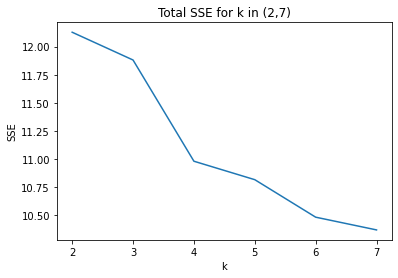

In [228]:
# Iris Classification using single-link without output label
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']

sse = []
print("We normalize the data")
for k in range(2,8):
    # Train
    HAC = HACClustering(k=k)
    HAC.fit(data)
    # Get data 
    sse.append(np.sum(HAC.sses))

# Plot SSE
plt.plot(list(range(2,8)), sse)
plt.title("Total SSE for k in (2,7)")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

We normalize the data


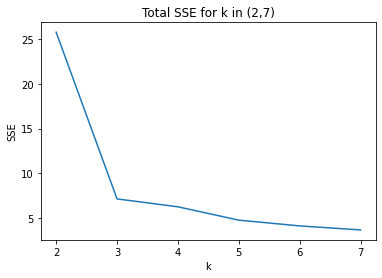

In [229]:
# Iris Classification using complete-link without output label
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']

sse = []
print("We normalize the data")
for k in range(2,8):
    # Train
    HAC = HACClustering(k=k, link_type='complete')
    HAC.fit(data)
    # Get data 
    sse.append(np.sum(HAC.sses))

# Plot SSE
plt.plot(list(range(2,8)), sse)
plt.title("Total SSE for k in (2,7)")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

Discuss differences between single-link and complete-link

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

We normalize the data


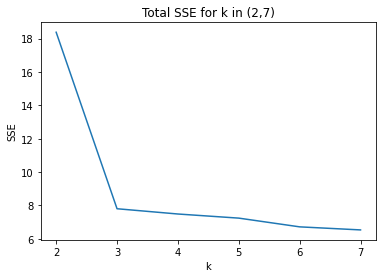

In [230]:
# Clustering Labels using single-link with output label
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']
iris_info = np.vstack((data.T,target)).T

sse = []
print("We normalize the data")
for k in range(2,8):
    # Train
    HAC = HACClustering(k=k)
    HAC.fit(iris_info)
    # Get data 
    sse.append(np.sum(HAC.sses))

# Plot SSE
plt.plot(list(range(2,8)), sse)
plt.title("Total SSE for k in (2,7)")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

We normalize the data


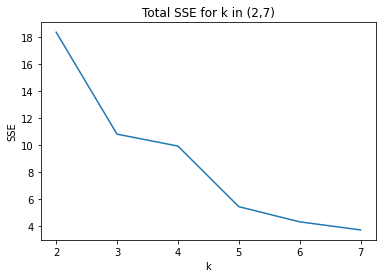

In [231]:
# Clustering Labels using complete-link with output label
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']
iris_info = np.vstack((data.T,target)).T

sse = []
print("We normalize the data")
for k in range(2,8):
    # Train
    HAC = HACClustering(k=k, link_type='complete')
    HAC.fit(iris_info)
    # Get data 
    sse.append(np.sum(HAC.sses))

# Plot SSE
plt.plot(list(range(2,8)), sse)
plt.title("Total SSE for k in (2,7)")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

Discuss any differences between the results from 2.1.1 and 2.1.2.

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made).
---

exiting at 6 iters
exiting at 5 iters
exiting at 7 iters
exiting at 8 iters
exiting at 9 iters
exiting at 9 iters


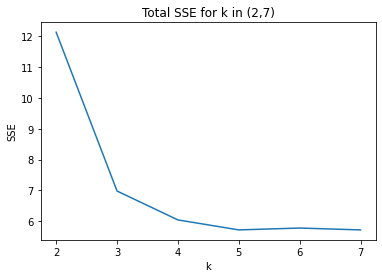

In [55]:
# Iris Classification without output label
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']

sse = []
for k in range(2,8):
    # Train
    model = KMEANSClustering(k=k, debug=True)
    model.fit(data)
    # Get data 
    sse.append(np.sum(model.sses))

# Plot SSE
plt.plot(list(range(2,8)), sse)
plt.title("Total SSE for k in (2,7)")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

exiting at 4 iters
exiting at 6 iters
exiting at 7 iters
exiting at 6 iters
exiting at 5 iters
exiting at 5 iters


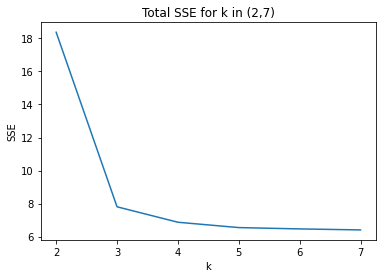

In [56]:
# Iris Classification with output label# Iris Classification without output label
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']
iris_info = np.vstack((data.T,target)).T

sse = []
for k in range(2,8):
    # Train
    model = KMEANSClustering(k=k, debug=True)
    model.fit(iris_info)
    # Get data 
    sse.append(np.sum(model.sses))

# Plot SSE
plt.plot(list(range(2,8)), sse)
plt.title("Total SSE for k in (2,7)")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

Compare results and differences between using the output label and excluding the output label

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

exiting at 6 iters
exiting at 7 iters
exiting at 6 iters
exiting at 5 iters
exiting at 5 iters


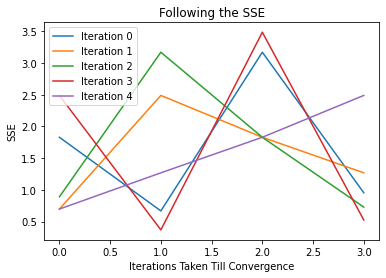

In [57]:
#K-Means 5 times
sses = []
for i in range(5):
    model = KMEANSClustering(k=4)
    model.fit(iris_info)
    # Get data 
    sses.append(model.sses)

for i,sse in enumerate(sses):
    plt.plot(sse, label=f'Iteration {i}')
plt.ylabel("SSE")
plt.xlabel('Iterations Taken Till Convergence')
plt.title("Following the SSE")
plt.legend()
plt.show()

Discuss any variations in the results

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

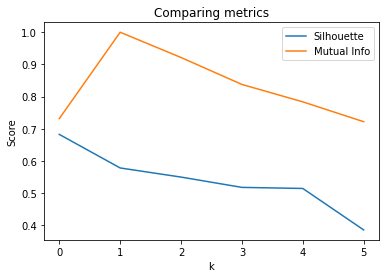

In [58]:
# Load sklearn 
sil_scores = []
mutual_info = []
for k in range(2,8):
    model = AC(k)
    model.fit(iris_info)
    sil_scores.append(silhouette_score(iris_info, model.labels_))
    mutual_info.append(mis(target, model.labels_))
plt.plot(sil_scores, label='Silhouette')
plt.plot(mutual_info, label='Mutual Info')
plt.title("Comparing metrics")
plt.xlabel("k")
plt.ylabel('Score')
plt.legend()
plt.show()

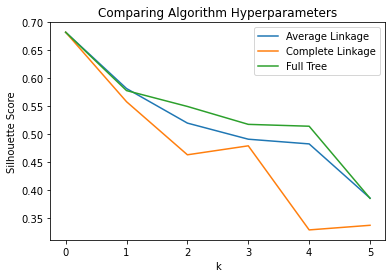

In [60]:
auto, full, elkan = [], [], []
for k in range(2,8):
    model = AC(k, linkage='average')
    model.fit(iris_info)
    auto.append(silhouette_score(iris_info, model.labels_))
    model = AC(k, linkage='complete')
    model.fit(iris_info)
    full.append(silhouette_score(iris_info, model.labels_))
    model = AC(k, compute_full_tree=True)
    model.fit(iris_info)
    elkan.append(silhouette_score(iris_info, model.labels_))
plt.plot(auto, label='Average Linkage')
plt.plot(full, label='Complete Linkage')
plt.plot(elkan, label='Full Tree')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Comparing Algorithm Hyperparameters')
plt.legend()
plt.show()

*Record impressions*

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

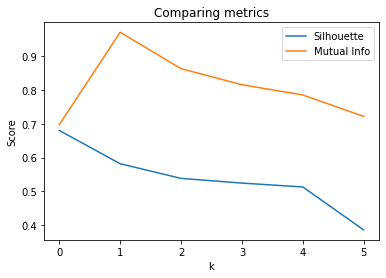

In [61]:
# Load sklearn 
sil_scores = []
mutual_info = []
for k in range(2,8):
    model = KMeans(k)
    model.fit(iris_info)
    sil_scores.append(silhouette_score(iris_info, model.labels_))
    mutual_info.append(mis(target, model.labels_))
plt.plot(sil_scores, label='Silhouette')
plt.plot(mutual_info, label='Mutual Info')
plt.title("Comparing metrics")
plt.xlabel("k")
plt.ylabel('Score')
plt.legend()
plt.show()

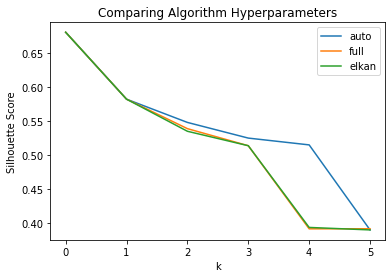

In [62]:
auto, full, elkan = [], [], []
for k in range(2,8):
    model = KMeans(k, algorithm='auto')
    model.fit(iris_info)
    auto.append(silhouette_score(iris_info, model.labels_))
    model = KMeans(k, algorithm='full')
    model.fit(iris_info)
    full.append(silhouette_score(iris_info, model.labels_))
    odel = KMeans(k, algorithm='elkan')
    model.fit(iris_info)
    elkan.append(silhouette_score(iris_info, model.labels_))
plt.plot(auto, label='auto')
plt.plot(full, label='full')
plt.plot(elkan, label='elkan')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Comparing Algorithm Hyperparameters')
plt.legend()
plt.show()

*Record impressions*

## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 


*Show findings here*